[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/timsainb/tensorflow2-generative-models/blob/master/4.0-seq2seq-fashion-mnist.ipynb)

## Seq2Seq Autoencoder (without attention)  

Seq2Seq models use recurrent neural network cells (like LSTMs) to better capture sequential organization in data. This implementation uses Convolutional Layers as input to the LSTM cells, and a single Bidirectional LSTM layer. 

![a seq2seq bidirectional lstm in tensorflow 2.0](imgs/seq2seq.png)

#### Note: We're treating fashion MNIST like a sequence (on it's x-axis) here. To see the same network on a more-sequential dataset - see the nsynth example! In addition - our base clase is the same autoencoder as 0.0, because we want a one dimensional z-space

### Install packages if in colab

In [ ]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

### load packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
print(tf.__version__)

2.0.0-dev20190513


### Create a fashion-MNIST dataset

In [6]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [7]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

### Define the network as tf.keras.model object

In [8]:
class AE(tf.keras.Model):
    """a basic autoencoder class for tensorflow
    Extends:
        tf.keras.Model
    """
    def __init__(self, **kwargs):
        super(AE, self).__init__()
        self.__dict__.update(kwargs)
         
        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    @tf.function
    def encode(self, x):
        return self.enc(x)

    @tf.function
    def decode(self, z):
        return self.dec(z)
    
    @tf.function
    def compute_loss(self, x):
        z = self.encode(x)
        _x = self.decode(z)
        ae_loss = tf.reduce_mean(tf.square(x - _x))
        return ae_loss
    
    @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):    
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables)) 

### Define the network architecture

In [9]:
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM
)
#from tensorflow.keras.layers import UnifiedLSTM as LSTM

N_Z = 128
shape_final = (7,7,64) # x channel will be the sequence length

enc = [
    Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    Conv2D(
        filters=shape_final[2], kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    Reshape(target_shape=(shape_final[0], np.prod(shape_final[1:]))),
    Bidirectional(LSTM(units=100, activation="relu")),
    Dense(units=512),
    Dense(units=N_Z),
]

dec = [
    Dense(units=512),
    RepeatVector(shape_final[0]),
    Bidirectional(LSTM(units=100, activation="relu", return_sequences=True)),
    TimeDistributed(Dense(np.prod(shape_final[1:]))),
    Reshape(target_shape=(shape_final[0], shape_final[1], shape_final[2])),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
    Reshape(target_shape=(28, 28, 1)),
]

In [10]:
shape_final[1:]

(7, 64)

### Create Model

In [11]:
# optimizers
optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

# model
model = AE(
    enc = enc,
    dec = dec,
    optimizer = optimizer,
)

### Train the model

In [12]:
# exampled data for plotting results
example_data = next(iter(test_dataset))

In [13]:
def plot_reconstruction(model, example_data, nex=5, zm=2):

    example_data_reconstructed = model.decode(model.encode(example_data))
    fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(zm * nex, zm * 2))
    for exi in range(nex):
        axs[0, exi].matshow(
            example_data.numpy()[exi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
        )
        axs[1, exi].matshow(
            example_data_reconstructed.numpy()[exi].squeeze(),
            cmap=plt.cm.Greys,
            vmin=0,
            vmax=1,
        )
    for ax in axs.flatten():
        ax.axis("off")
    plt.show()

In [14]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['MSE'])

Epoch: 49 | MSE: 0.007553647272288799


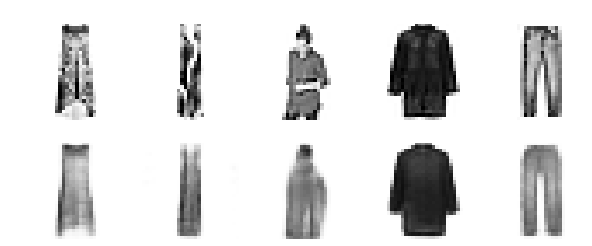

In [16]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | MSE: {}".format(
            epoch, losses.MSE.values[-1]
        )
    )
    plot_reconstruction(model, example_data)

### Plot loss

Text(0.5, 0, 'Epoch')

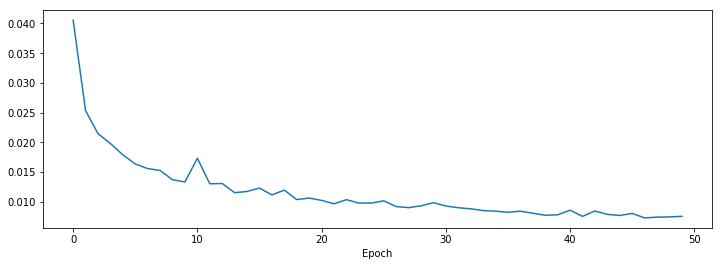

In [17]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(losses.MSE)
ax.set_xlabel('MSE')
ax.set_xlabel('Epoch')